#### Simplest model with one conv layer and 1 fully-connected hidden layer 
#### Same as v3
#### Added test
#### Visualization of loss and test curves

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import time

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [3]:
image_height = 480
image_width = 720

def load_data(test=False):
    fname = 'test.csv' if test else 'FLIC_dataset.csv'
    df = pd.read_csv(fname, nrows = 300)
    del df['Unnamed: 0']
    cols = df.columns[:-1]
    y = df[cols]
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' ') / 255.0)
    df = df.dropna()
    X = np.vstack(df['Image'])
    X = X.reshape(-1, image_height, image_width, 1)
    
    if not test:
        y1 = y.ix[:,0:9] / 720.0
        y2 = y.ix[:,9:] / 480.0
        y = pd.concat([y1, y2], axis = 1)
        X, y = shuffle(X, y)

    else:
        y = None
    return X, y

In [4]:
x,y = load_data()
print (x.shape)

(300, 480, 720, 1)


In [5]:
# To evaluate how good a prediction is
def eval_error(pred, ground_truth):
    return np.sqrt(mean_squared_error(pred, ground_truth))

In [6]:
from sklearn.cross_validation import train_test_split
x_train, x_valid, y_train,y_valid = train_test_split(x, y, test_size = 0.2, random_state=0)
print ("x_train has shape of:")
print (x_train.shape)

x_train has shape of:
(240, 480, 720, 1)


In [7]:
## -------------------------------------------------------------------------
## Here is the start of the TF graph
## -------------------------------------------------------------------------
batch_size = 16
image_height = 480
image_width = 720
num_channels = 1
num_labels = 18

deep_graph = tf.Graph()
with deep_graph.as_default():

    tf_valid_dataset = tf.constant(x_valid, dtype = tf.float32)
    #tf_test_dataset = tf.constant(x_test, dtype = tf.float32) 

    tf_train_dataset = tf.placeholder(
        tf.float32, 
        shape = (batch_size, image_height, image_width, num_channels))

    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))

    conv1_weight = tf.Variable(
        tf.truncated_normal([5, 5, num_channels, 32], 
                            stddev = 0.1, seed = 0))

    conv1_biases = tf.Variable(tf.zeros([32]))

#     conv2_weights = tf.Variable(
#             tf.truncated_normal([5, 5, 32, 64], 
#                                 stddev = 0.1, seed = 0, dtype = tf.float32))

#     conv2_biases = tf.Variable(tf.constant(0.1, shape = [64]))

    fc1_weights = tf.Variable(
        tf.truncated_normal([image_height * image_width * 8 , num_labels], 
                            stddev = 0.1, seed = 0, dtype = tf.float32))

    fc1_biases = tf.Variable(tf.constant(0.1, shape = [num_labels]))

#     fc2_weights = tf.Variable(
#         tf.truncated_normal([512, 512], 
#                             stddev = 0.1, seed = 0, dtype = tf.float32))

#     fc2_biases = tf.Variable(tf.constant(0.1, shape = [512]))

#     fc3_weights = tf.Variable(
#         tf.truncated_normal([512, num_labels], stddev = 0.1, seed = 0, dtype = tf.float32))

#     fc3_biases = tf.Variable(tf.constant(0.1, shape = [num_labels]))

    def model(data, train = False):
        conv1 = tf.nn.conv2d(data, conv1_weight, strides = [1,1,1,1], padding = 'SAME')

        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))

        pool1 = tf.nn.max_pool(relu1, ksize = [1, 2, 2, 1], 
                                strides = [1, 2, 2, 1], padding = 'SAME')

#         conv2 = tf.nn.conv2d(pool1, conv2_weights, strides = [1, 1, 1, 1], padding = 'SAME')

#         relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))

#         pool2 = tf.nn.max_pool(relu2, ksize = [1, 2, 2, 1],
#                                 strides = [1, 1, 1, 1], padding = 'SAME')

        # Reshape the feature map cuboid into a 2D matrix to feed it to the
        # fully connected layers.
        pool_shape = pool1.get_shape().as_list()
        reshape = tf.reshape(pool1, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
#         reshape = tf.Print(reshape, [reshape], "reshape: ", summarize=10)
        print (reshape.get_shape())
        # Fully connecte layers
        hidden_layer1 = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        # For training data, add 0.5 dropout. 
        return hidden_layer1
        
#         if train:
#             hidden_layer1 = tf.nn.dropout(hidden_layer1, 0.5, seed = 0)

#         hidden_layer2 = tf.nn.relu(tf.matmul(hidden_layer1, fc2_weights) + fc2_biases)

#         if train:
#             hidden_layer2 = tf.nn.dropout(hidden_layer2, 0.5, seed = 0)

#         return tf.matmul(hidden_layer2, fc3_weights) + fc3_biases

    # Call the model() function to make train_prediction
    train_prediction = model(tf_train_dataset, True)
    valid_prediction = model(tf_valid_dataset)
    # calculate loss by using train_prediction
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(train_prediction - tf_train_labels), 1))
    # Add L2 regularization to loss
#     loss += 1e-7 * (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
#             tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases) + 
#             tf.nn.l2_loss(fc3_weights) + tf.nn.l2_loss(fc3_biases)) 

    # Optimizer
    global_step = tf.Variable(0, name = 'global_step',trainable = False)
    starter_learning_rate = 0.001
    learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                                global_step,
                                                100000,
                                                0.96,
                                                staircase = True)

    optimizer = tf.train.AdamOptimizer(learning_rate, 0.95).minimize(loss, global_step = global_step)       

TensorShape([Dimension(16), Dimension(2764800)])
TensorShape([Dimension(60), Dimension(2764800)])


In [8]:
## ------------------------------------------------------------------------
## Now we can use the TF graph
## ------------------------------------------------------------------------
print ("Start running TF graph ... ")
num_steps = 101

train_acc_records = np.zeros(num_steps)
valid_acc_records = np.zeros(num_steps)
# test_acc_records = np.zeros(num_steps)
loss_records = np.zeros(num_steps)

start_time = time.time()

with tf.Session(graph=deep_graph) as sess:
    tf.initialize_all_variables().run()
    #tf.global_variables_initializer().run()
    print ("TF graph variables initialized ... ")
 
    for step in range(num_steps):
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)

        batch_data = x_train[offset:(offset + batch_size),:]
        batch_labels = y_train[offset:(offset + batch_size)]
        print (batch_labels.shape)
        
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}

        _,l, pred = sess.run([optimizer, loss, train_prediction], feed_dict = feed_dict)

        train_acc_records[step] = eval_error(pred, batch_labels)
        valid_acc_records[step] = eval_error(valid_prediction.eval(), y_valid)
#         test_acc_records[step] = eval_error(test_prediction.eval(), y_test)

        if (step % 2) == 0:
            print ("Minibatch loss at step %d: %f" % (step, l))
#             print ("Minibatch RMSE: %0.5f" % train_acc_records[step])
            print ("Validation RMSE: %0.5f" % valid_acc_records[step])
#             print ("Test RMSE: %0.5f" % test_acc_records[step])
    time_elasped = time.time() - start_time
    print ("==================================")
    print ("Net finished training!")

Start running TF graph ... 
TF graph variables initialized ... 
(16, 18)
Minibatch loss at step 0: 6075.998047
Validation RMSE: 0.58837
(16, 18)
(16, 18)
Minibatch loss at step 2: 4.264675
Validation RMSE: 0.53871
(16, 18)
(16, 18)
Minibatch loss at step 4: 4.943174
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 6: 5.284591
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 8: 4.706374
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 10: 5.685203
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 12: 4.745906
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 14: 5.656637
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 16: 4.264675
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 18: 4.943174
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 20: 5.284591
Validation RMSE: 0.53872
(16, 18)
(16, 18)
Minibatch loss at step 22: 4.721578
Validation RMSE: 0.53872

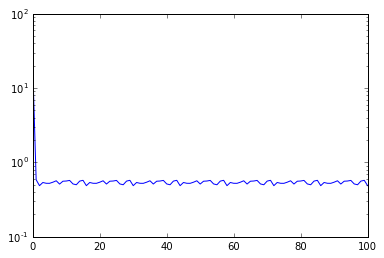

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogy(train_acc_records)